# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs

input_file = "data/data-continental-united-states.csv"
# input_file = "data/data-nh-vt.csv"
geocode_precision = 4
# geocode_precision = 5
log_file = "run.log"
num_clusters = 60
taxon_filter = "Insecta"

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


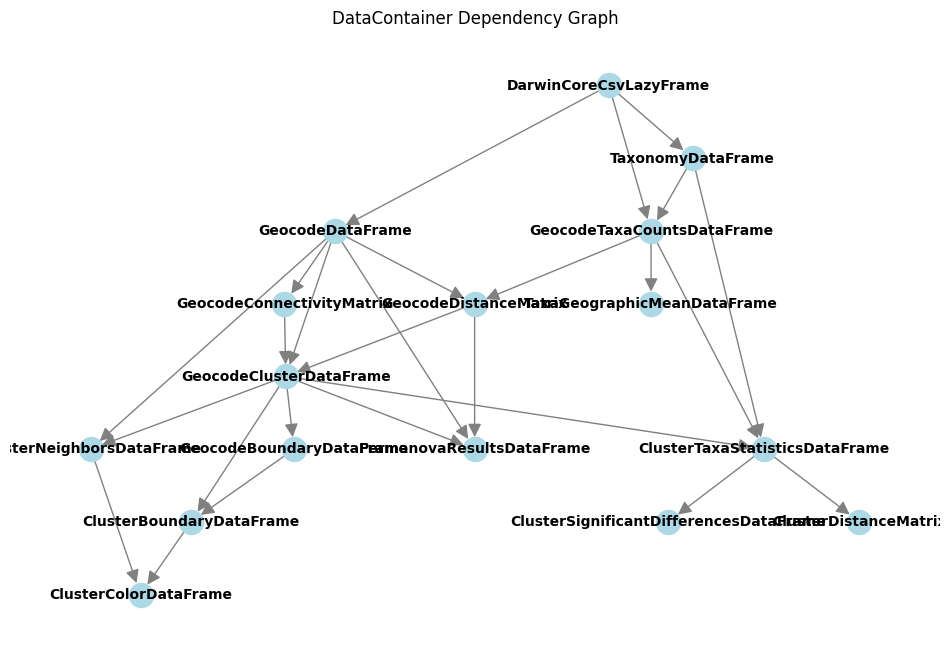

In [3]:
from inaturalist_ecoregions.dependency_graph import plot_dependency_graph

plot_dependency_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from inaturalist_ecoregions.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(
    input_file, taxon_filter=taxon_filter
)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from inaturalist_ecoregions.dataframes.geocode import GeocodeDataFrame

geocode_dataframe = GeocodeDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Preview

In [7]:
geocode_dataframe.df

geocode,center,direct_neighbors,direct_and_indirect_neighbors
str,struct[2],list[str],list[str]
"""840e491ffffffff""","{49.369298,-67.913007}","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]"
"""840e493ffffffff""","{48.946311,-67.83016}","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]"
"""840e497ffffffff""","{49.104076,-68.442117}","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]"
"""840e49bffffffff""","{49.208357,-67.299825}","[""840e491ffffffff"", ""840e493ffffffff"", … ""842b327ffffffff""]","[""840e491ffffffff"", ""840e493ffffffff"", … ""842b327ffffffff""]"
"""840e4b1ffffffff""","{49.410776,-69.681628}","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]"
…,…,…,…
"""844da39ffffffff""","{29.518714,-68.472339}",[],"[""844db1bffffffff""]"
"""844db1bffffffff""","{29.95183,-70.105581}",[],"[""844d86dffffffff"", ""842a5b3ffffffff"", ""844da39ffffffff""]"
"""844db61ffffffff""","{31.586253,-71.677466}",[],"[""842acc9ffffffff"", ""844d86dffffffff""]"


## `TaxonomyDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [ ]:
taxonomy_dataframe.df

## `GeohashSpeciesCountsDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.geocode_taxa_counts import GeocodeTaxaCountsDataFrame

geocode_taxa_counts_dataframe = GeocodeTaxaCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
    taxonomy_dataframe,
)

### Preview

In [ ]:
geocode_taxa_counts_dataframe.df

## `GeocodeConnectivityMatrix`

### Build

In [ ]:
from inaturalist_ecoregions.matrices.geocode_connectivity import GeocodeConnectivityMatrix

geocode_connectivity_matrix = GeocodeConnectivityMatrix.build(geocode_dataframe)

### Shape

In [ ]:
geocode_connectivity_matrix._connectivity_matrix.shape

### Preview

In [ ]:
geocode_connectivity_matrix._connectivity_matrix

## `GeocodeDistanceMatrix`

In [ ]:
from inaturalist_ecoregions.matrices.geocode_distance import GeocodeDistanceMatrix

print(GeocodeDistanceMatrix.__doc__)

### Build

In [ ]:
geocode_distance_matrix = GeocodeDistanceMatrix.build(
    geocode_taxa_counts_dataframe,
    geocode_dataframe,
)

### Shape

In [ ]:
geocode_distance_matrix.squareform().shape

### Preview

In [ ]:
geocode_distance_matrix.squareform()

## `GeohashClusterDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.geocode_cluster import GeocodeClusterDataFrame

geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
    geocode_dataframe,
    geocode_distance_matrix,
    geocode_connectivity_matrix,
    num_clusters,
)

### Preview

In [ ]:
geocode_cluster_dataframe.df.limit(3)

In [ ]:
# # TMP

# from inaturalist_ecoregions.dataframes.geocode_cluster import GeocodeClusterDataFrame
# from sklearn.metrics import silhouette_score

# results = []

# for i in range(2, 200):
#     geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
#         geocode_dataframe,
#         distance_matrix,
#         connectivity_matrix,
#         num_clusters=i,
#     )
#     score = silhouette_score(
#         X=distance_matrix.squareform(),
#         labels=geocode_cluster_dataframe.df["cluster"],
#         metric="precomputed",
#     )
#     print(f"{i}: {score}")
#     results.append((i, score))

# results

## `ClusterNeighborsDataframe`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.cluster_neighbors import ClusterNeighborsDataFrame

cluster_neighbors_dataframe = ClusterNeighborsDataFrame.build(
    geocode_dataframe,
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
cluster_neighbors_dataframe.df

## `ClusterTaxaStatisticsDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geocode_taxa_counts_dataframe,
    geocode_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [ ]:
cluster_taxa_statistics_dataframe.df

## `ClusterSignificantDifferencesDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.cluster_significant_differences import (
    ClusterSignificantDifferencesDataFrame,
)

cluster_significant_differences_dataframe = (
    ClusterSignificantDifferencesDataFrame.build(
        cluster_taxa_statistics_dataframe,
    )
)

### Preview

In [ ]:
cluster_significant_differences_dataframe.df.limit(3)

## `GeocodeBoundaryDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.geocode_boundary import GeocodeBoundaryDataFrame

geocode_boundary_dataframe = GeocodeBoundaryDataFrame.build(
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
geocode_boundary_dataframe.df

## `ClusterBoundaryDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.cluster_boundary import ClusterBoundaryDataFrame

cluster_boundary_dataframe = ClusterBoundaryDataFrame.build(
    geocode_cluster_dataframe,
    geocode_boundary_dataframe,
)

### Preview

In [ ]:
cluster_boundary_dataframe.df

## `ClusterDistanceMatrix`

### Build

In [ ]:
from inaturalist_ecoregions.matrices.cluster_distance import ClusterDistanceMatrix

cluster_distance_matrix = ClusterDistanceMatrix.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [ ]:
cluster_distance_matrix.squareform()

## `ClusterColorDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(
    cluster_neighbors_dataframe,
    cluster_boundary_dataframe,
    cluster_taxa_statistics_dataframe,
    color_method="taxonomic",
    # color_method="geographic",
)

### Preview

In [ ]:
cluster_colors_dataframe.df

## `GeocodeSilhouetteScoreDataFrame`

### Build

In [ ]:
from inaturalist_ecoregions.dataframes.geocode_silhouette_score import GeocodeSilhouetteScoreDataFrame

geocode_silhouette_score_dataframe = GeocodeSilhouetteScoreDataFrame.build(
    cluster_neighbors_dataframe,
    geocode_distance_matrix,
    geocode_cluster_dataframe,
)

### Preview

In [ ]:
geocode_silhouette_score_dataframe.df.sort(by="silhouette_score")

In [ ]:
from inaturalist_ecoregions.plot.silhouette_score import plot_silhouette_scores

plot_silhouette_scores(
    geocode_cluster_dataframe,
    geocode_distance_matrix,
    geocode_silhouette_score_dataframe,
    cluster_colors_dataframe,
)

## Build and plot GeoJSON feature collection

In [ ]:
from inaturalist_ecoregions.geojson import build_geojson_feature_collection, write_geojson
from inaturalist_ecoregions.render import plot_clusters
from inaturalist_ecoregions import output
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [12, 7]

feature_collection = build_geojson_feature_collection(
    cluster_boundary_dataframe,
    cluster_colors_dataframe,
)

write_geojson(feature_collection, output.get_geojson_path())
plot_clusters(feature_collection)

## Build and display HTML output

In [ ]:
from inaturalist_ecoregions.html_output import prepare_full_report_data, render_html, write_html

report_data = prepare_full_report_data(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
    taxonomy_dataframe,
    feature_collection,
)
html_content = render_html("cluster_report.html", report_data)
html_output = output.get_html_path()
write_html(html_content, html_output)

## Dimensionality reduction plot

In [ ]:
from inaturalist_ecoregions.plot.dimnesionality_reduction import create_dimensionality_reduction_plot

create_dimensionality_reduction_plot(
    geocode_distance_matrix,
    geocode_cluster_dataframe,
    cluster_colors_dataframe,
    method="umap",
)

## Clustermap visualization

In [ ]:
from inaturalist_ecoregions.plot.cluster_taxa import create_cluster_taxa_heatmap

create_cluster_taxa_heatmap(
    geocode_dataframe=geocode_dataframe,
    geocode_cluster_dataframe=geocode_cluster_dataframe,
    cluster_colors_dataframe=cluster_colors_dataframe,
    geocode_distance_matrix=geocode_distance_matrix,
    cluster_significant_differences_dataframe=cluster_significant_differences_dataframe,
    taxonomy_dataframe=taxonomy_dataframe,
    geocode_taxa_counts_dataframe=geocode_taxa_counts_dataframe,
    cluster_taxa_statistics_dataframe=cluster_taxa_statistics_dataframe,
    limit_species=5,
)